## Activity
1. Use a data search tool to find an interesting, publicly available data source. Identify the format of the data from the API.
2. Read in the data into a new DataFrame object.
3. Create a visualization of at least one variable from the DataFrame using the Seaborn library.
4. Briefly interpret the visualization.

In [91]:
import sys, os
import pandas as pd
import json
from pandas.io.json import json_normalize
from datetime import datetime

### Presidential Debate Data 1960 - 2020
A quick word study of all presidential debates and candidates usage of 'America' and 'American(s).' The data comes from a Kaggle database [US Presidential Debate Transcripts 1960-2020](https://www.kaggle.com/datasets/arenagrenade/us-presidential-debate-transcripts-19602020). There were no presidential debates between 1964 – 1972.

Import all json files into dataframes and concatenate all 'dialogue' spoken by each 'actor.' Actors include candidates and moderators. The date is generated from the filename of each json file.

In [133]:
df_list = []
directory = 'data/pres_debates/'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    with open(f) as json_data:
        data = json.load(json_data)
        df = pd.DataFrame(data['content'])
        concat_dial = df.groupby(['actor'])['dialogue'].apply(lambda x: ' '.join(x)).reset_index()
        last = len(filename)-1
        year = filename[last-8:last-4]
        month = filename[:last-12].capitalize()
        day = filename[last-11:last-9]
        s = day + " " + month + ", " + year
        d = datetime.strptime(s, '%d %B, %Y')
        concat_dial['date'] = d
        df_list.append(concat_dial)

pres_debates = pd.concat(df_list, ignore_index=True)
pres_debates.sort_values(by='date', inplace=True)
pres_debates

,actor,dialogue,date
12,Voice,This will allow three minutes and twenty secon...,1960-09-26
11,Mr. Warren,"Uh Senator Kennedy, during your brief speech ...",1960-09-26
5,Mr. Fleming,"Senator, the Vice President in his campaign ha...",1960-09-26
6,Mr. Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",1960-09-26
7,Mr. Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",1960-09-26
...,...,...,...
24,Participants,Former Vice President Joe Biden (D) and,2020-10-22
25,Trump,"So, as you know, 2.2 million people, modeled o...",2020-10-22
26,Welker,Good evening from Belmont University in Nashvi...,2020-10-22
22,Biden,"220,000 Americans dead. If you hear nothing el...",2020-10-22


Filter out all non-candidates based on list of last names to be kept.

In [134]:
candidates = ['Nixon', 'Kennedy', 'Ford', 'Carter', 'Reagan', 'Anderson', 'Mondale', 'Bush', 'Dukakis', 'Clinton', 'Perot', 'Dole', 'Gore', 'Kerry', 'McCain', 'Obama', 'Romney', 'Trump', 'Biden']
cand_only = pres_debates[pres_debates['actor'].str.contains('|'.join(candidates))]
cand_only.reset_index(inplace=True, drop=True)
cand_only


,actor,dialogue,date
0,Mr. Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",1960-09-26
1,Mr. Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",1960-09-26
2,Mr. Kennedy,In the first place Ive never suggested that Cu...,1960-10-07
3,Mr. Nixon,"Well first of all, I dont agree with Senator K...",1960-10-07
4,Mr. Kennedy,"Good evening, Mr. Shadel. Mr. McGee, we have a...",1960-10-13
...,...,...,...
70,Clinton,"Thank you very much, Chris. And thanks to UNLV...",2016-10-19
71,Trump,"How are you doing? Thank you very much, Chris....",2020-09-29
72,Biden,"How you doing, man? Im well. Well, first of al...",2020-09-29
73,Trump,"So, as you know, 2.2 million people, modeled o...",2020-10-22


In [114]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from itertools import dropwhile
from copy import deepcopy

Tokenization of each candidates dialogue into a dataframe, which is search for occurences of the string 'America.' These counts are summarized into a new column.

In [136]:
stop_words = set(stopwords.words("english"))  # load stopwords

def tokenize(data):
    words = [w for w in data.split(" ") if w not in stop_words]

    new_data = Counter(words)

    for key, count in dropwhile(lambda key_count: key_count[1] >= 2, new_data.most_common()):
        del new_data[key]

    df = pd.DataFrame.from_dict(new_data.most_common())
    df.columns = ['word', 'occurrences']
    return df

def occurrences(word, df):
    new_df = df.loc[df['word'].str.contains(word)]
    return new_df['occurrences'].sum()

cand_only['America'] = cand_only.apply(lambda row : occurrences('America', tokenize(row['dialogue'])), axis = 1)
cand_only

/var/folders/n3/7lr2xtgs72g16rs2rfk0gvgw0000gn/T/ipykernel_99434/3568524964.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cand_only['America'] = cand_only.apply(lambda row : occurrences('America', tokenize(row['dialogue'])), axis = 1)


,actor,dialogue,date,America
0,Mr. Kennedy,"Mr. Smith, Mr. Nixon. In the election of 1860,...",1960-09-26,16
1,Mr. Nixon,"Mr. Smith, Senator Kennedy. The things that Se...",1960-09-26,8
2,Mr. Kennedy,In the first place Ive never suggested that Cu...,1960-10-07,14
3,Mr. Nixon,"Well first of all, I dont agree with Senator K...",1960-10-07,20
4,Mr. Kennedy,"Good evening, Mr. Shadel. Mr. McGee, we have a...",1960-10-13,4
...,...,...,...,...
70,Clinton,"Thank you very much, Chris. And thanks to UNLV...",2016-10-19,26
71,Trump,"How are you doing? Thank you very much, Chris....",2020-09-29,0
72,Biden,"How you doing, man? Im well. Well, first of al...",2020-09-29,23
73,Trump,"So, as you know, 2.2 million people, modeled o...",2020-10-22,2


A quick demo with Seaborn, a lot of improvements to be discovered with grouping, labeling, and color palette.

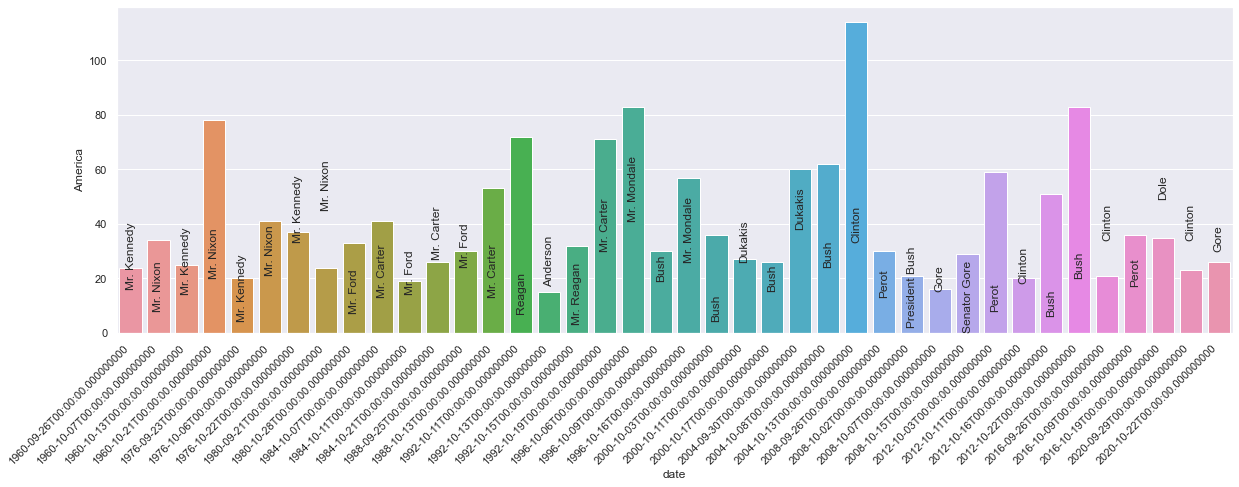

In [154]:
from calendar import c
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

fig, ax = plt.subplots(figsize = (20,6))    
fig = sns.barplot(x = "date", y = "America", data = cand_only, 
                  estimator = sum, ci = None, ax=ax)

x_dates = cand_only['date'].sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

for i in cand_only.index:
    word = cand_only.loc[i, "actor"]
    y = cand_only.loc[i, "America"]
    plt.annotate(word, (i, y), ha="center", va="bottom", rotation=90)


It's somewhat difficult to make any conclusions about this particular data set at the moment. The Seaborn chart, the way it's currently mapped does not allow for all debates to be included and some date labels are off. 2020 is labeled as Clinton and Gore, which of course is not the case.

